In [1]:
import numpy as np
import torch
import gym
import matplotlib
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
%matplotlib inline

from collections import deque
from IPython import display

In [2]:
# run following command to install atari:
# !pip3 install gym[atari]

# if atari failed to build run:
# !sudo apt install cmake libz-dev

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

cuda


In [4]:
class QFunction(object):
        
    def __init__(self, obssize, actsize):
        """
        obssize: int dimension of state spac
        actsize: int dimension of action space
        optimizer: torch optimizer
        """
        self.obssize = obssize
        self.actsize = actsize
        self.net = self.Net(obssize, actsize)
        self.loss_fn = nn.MSELoss()
        
    def pred(self, states):
        """
        Args
            states: torch.tensor (batch_size, obssize)
            actions: torch.tensor (batch_size, 1) index of the action to be taken
        Return
            torch.tensor (batch_size, actsize) of Q(s,a) value of every action for s
        """
        return self.net(states) # shape (batch_size, actsize)
        
    def loss(self, states, actions, target):
        """
        Args
            states: torch.tensor (batch_size, obssize)
            actions: torch.tensor (batch_size, 1) index of the action to be taken
        Return
            Qpreds: torch.tensor (batch_size, actsize) of Q(s,a) value of every action for s
        """
        Qpreds = self.net(states)
        Qpreds = Qpreds.gather(1, actions.view(-1,1)) # get Q(s,a) for every action a
        return self.loss_fn(Qpreds, target)
    
    def train(self, states, actions, target):
        """Returns loss"""
        self.optimizer.zero_grad()
        loss = self.loss(states, actions, target)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def init_op(self, lr, params):
        """Initialize Optimizer: Adam Optimizer"""
        self.optimizer = optim.Adam(self.net.parameters(),lr, params)
        
    """Neural Network built here"""
    class Net(nn.Module):
        def __init__(self, input_size, output_size):
            super(QFunction.Net, self).__init__()
            #layer sizes
            layer_sizes = [256, 256]
            
            # defining hidden layers
            self.layer1 = nn.Linear(input_size, layer_sizes[0])
            self.layer2 = nn.Linear(layer_sizes[0], layer_sizes[1])
            
            # activation
            self.sigma = nn.ReLU()
            # output logit layer
            self.output_layer = nn.Linear(layer_sizes[1], output_size)
            
        def forward(self, X):
            X = self.sigma(self.layer1(X))
            X = self.sigma(self.layer2(X))
            output = self.output_layer(X)
            return output
        

In [5]:
# Implement replay buffer (Courtesy of IEOR 8100 lab3-DQN)
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime, priority)
        """
        self.buffer.append(experience)
        self.number += 1
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime, priority)
        """
        # YOUR CODE HERE
        R = []
        for i in range(batchsize):
            R.append(self.buffer[np.random.randint(self.number)])
        return R
    
    def ada_sample(self, batchsize, priorities):
        """
        adaptive sample from buffer given priority probability
        priority_prob: array of priority probability
        return: a list of tuples of form (s,a,r,s^\prime, priority)
        """
        pr_prob = priorities / sum(priorities)
        idxs = np.random.choice(len(self.buffer), batchsize, p=pr_prob)
        return [self.buffer[i] for i in idxs]

In [6]:
def update_target_weights(principal, target, beta=0.8):

    for (p_name, p_weights), (t_name, t_weights) in zip(principal.net.state_dict().items(),target.net.state_dict().items()):
        # Don't update if this is not a weight.
        if not "weight" in p_name:
            continue

        # Transform the parameter as required.
        new_weights = (1-beta) * p_weights + beta * t_weights

        # Update the parameter.
        target.net.state_dict()[t_name].copy_(new_weights)

In [7]:
#plotting
from pylab import plot
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')

In [8]:
# initialize environment
env = gym.make('MsPacman-ram-v0')
obssize = env.observation_space.low.size
actsize = env.action_space.n

In [9]:
# hyperparams
batch_size = 128
lr = 1e-3
betas=(0.9, 0.999)
epsilon = 0.4 # greedy exploration
gamma = 0.9
tau = 200 # num steps to update Q_target
episodes = 10000
sample_step = 1000 # number of episodes to collect samples before starting update
penalize = -5 # score to penalize if end of episodes
max_storage = 10000 # max. samples to store
eps_decay_steps = 25
eps_decay = 0.9988 # decays to ~.6 at 50000 and ~.25 at 25000
print_step = 100

# initialize Q and Q_target
q_network = QFunction(obssize, actsize)
q_network.init_op(lr, betas)

q_target = QFunction(obssize, actsize)
q_target.init_op(lr, betas)

q_network.net.to(device)
q_target.net.to(device)

buffer = ReplayBuffer(max_storage)

In [13]:
print("Sampling experiences from space...")
baseline_rewards = []
for ep in range(sample_step):
    s = env.reset()
    done = False
    count = 100
    if ep % count == 0:
        print("Starting Eps: {}/{}".format(ep, sample_step))
    rsum = 0
    while not done:
        a = env.action_space.sample()
        s1, r, done, _ = env.step(a)
        rsum += r
        if done:
            r = penalize
        buffer.append((s, a, r, s1))
    baseline_rewards.append(rsum)

Sampling experiences from space...
Starting Eps: 0/1000
Starting Eps: 100/1000
Starting Eps: 200/1000
Starting Eps: 300/1000
Starting Eps: 400/1000
Starting Eps: 500/1000
Starting Eps: 600/1000
Starting Eps: 700/1000
Starting Eps: 800/1000
Starting Eps: 900/1000


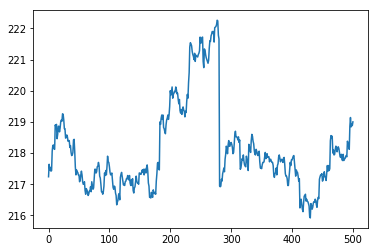

In [14]:
rm=movingaverage(baseline_rewards, 500)
plt.plot(rm)

In [ ]:
print("Starting training for Q...")
ep_rewards = []
for ep in range(episodes):
    s = env.reset()
    done = False
    count = 10
    if ep % count == 0:
        print("Starting Eps: {}/{}".format(ep, episodes))
        
    ep_rsum = 0
    while not done:
        s_ = torch.tensor(s, dtype=torch.float32)
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            Q = q_network.pred(s_.view(-1,len(s)))
            a = torch.argmax(Q,dim=1)
            
        s1, r, done, _ = env.step(a)
        ep_rsum += r
        if done:
            r = penalize
            
        buffer.append((s, a, r, s1))
        
    ### training ###
    replay = buffer.sample(batch_size)
    states, actions, rewards, states_1 = zip(*replay)
    
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions).view(batch_size, -1)
    rewards = torch.tensor(rewards).view(batch_size, -1)
    states_1 = torch.tensor(states_1, dtype=torch.float32)
    
    # compute targets
    Qtargets, _ = torch.max(q_target.pred(states_1),dim=1)
    Qtargets = rewards + gamma * Qtargets
    q_network.train(states, actions, Qtargets)
    
    if ep % tau == 0:
        print("Update q_target...")
        update_target_weights(q_network, q_target)
    
    if ep % print_step == 0:
        print("Total Reward for ep{}: {}".format(ep, ep_rsum))
        
    # for decaying epsilon-greedy
#     if (ep > 0) and (ep % eps_decay_steps == 0):
#         epsilon *= eps_decay

    ep_rewards.append(ep_rsum)

Starting training for Q...
Starting Eps: 0/10000
Update q_target...
Total Reward for ep0: 430.0
Starting Eps: 10/10000
Starting Eps: 20/10000
Starting Eps: 30/10000
Starting Eps: 40/10000
Starting Eps: 50/10000
Starting Eps: 60/10000
Starting Eps: 70/10000
Starting Eps: 80/10000
Starting Eps: 90/10000
Starting Eps: 100/10000
Total Reward for ep100: 540.0
Starting Eps: 110/10000
Starting Eps: 120/10000
Starting Eps: 130/10000
Starting Eps: 140/10000
Starting Eps: 150/10000
Starting Eps: 160/10000
Starting Eps: 170/10000
Starting Eps: 180/10000
Starting Eps: 190/10000
Starting Eps: 200/10000
Update q_target...
Total Reward for ep200: 300.0
Starting Eps: 210/10000
Starting Eps: 220/10000
Starting Eps: 230/10000
Starting Eps: 240/10000
Starting Eps: 250/10000
Starting Eps: 260/10000
Starting Eps: 270/10000
Starting Eps: 280/10000
Starting Eps: 290/10000
Starting Eps: 300/10000
Total Reward for ep300: 260.0
Starting Eps: 310/10000
Starting Eps: 320/10000
Starting Eps: 330/10000
Starting Eps

Starting Eps: 2850/10000
Starting Eps: 2860/10000
Starting Eps: 2870/10000
Starting Eps: 2880/10000
Starting Eps: 2890/10000
Starting Eps: 2900/10000
Total Reward for ep2900: 420.0
Starting Eps: 2910/10000
Starting Eps: 2920/10000
Starting Eps: 2930/10000
Starting Eps: 2940/10000
Starting Eps: 2950/10000
Starting Eps: 2960/10000
Starting Eps: 2970/10000
Starting Eps: 2980/10000
Starting Eps: 2990/10000
Starting Eps: 3000/10000
Update q_target...
Total Reward for ep3000: 1090.0
Starting Eps: 3010/10000
Starting Eps: 3020/10000
Starting Eps: 3030/10000
Starting Eps: 3040/10000
Starting Eps: 3050/10000
Starting Eps: 3060/10000
Starting Eps: 3070/10000
Starting Eps: 3080/10000
Starting Eps: 3090/10000
Starting Eps: 3100/10000
Total Reward for ep3100: 1250.0
Starting Eps: 3110/10000
Starting Eps: 3120/10000
Starting Eps: 3130/10000
Starting Eps: 3140/10000
Starting Eps: 3150/10000
Starting Eps: 3160/10000
Starting Eps: 3170/10000
Starting Eps: 3180/10000
Starting Eps: 3190/10000
Starting Ep

In [ ]:
rm=movingaverage(ep_rewards, 1000)
plt.plot(rm)

In [10]:
# save weights
# torch.save(q_network.net.state_dict(), './checkpoints/q_network_weights2')

In [23]:
# load weights
q_network.net.load_state_dict(torch.load('./checkpoints/q_network_weights2'))

To show plot, run jupyter notebook with `xvfb-run -s "-screen 0 1400x900x24" jupyter notebook`

In [12]:
def play(agent, env):
    s = env.reset()
    done = False
    rsum = 0
    actions = []
    while not done:
        s_ = torch.tensor(s, dtype=torch.float32)
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            Q = agent.pred(s_.view(-1,len(s)))
            a = torch.argmax(Q,dim=1)
            
        actions.append(a)
        s1, r, done, _ = env.step(a)
        rsum += r
    return actions, rsum

In [24]:
actions, rsum = play(q_network, env)

In [25]:
rsum

320.0

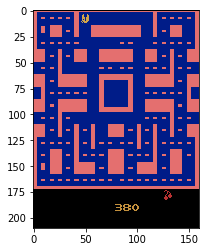

In [26]:
# Courtesy of https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for a in actions:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    env.step(a)